# PostgreSQL Vector Database with pgvector

This notebook demonstrates how to use PostgreSQL with the pgvector extension for vector similarity search. PostgreSQL offers a unique advantage: combining vector search with traditional SQL capabilities.

## Overview

While FAISS excels at pure vector operations, PostgreSQL with pgvector provides:
- ACID transactions for vector operations
- SQL integration (JOINs, filters, aggregations)
- Mature ecosystem (backups, monitoring, tooling)
- Existing infrastructure leverage

## Prerequisites

Before running this notebook, ensure PostgreSQL with pgvector is running:

```bash
# Start PostgreSQL with pgvector
task postgres-start

# Or using docker-compose directly
docker-compose up -d postgres-vector
```

## Setup and Imports

In [1]:
# Import required libraries
import os
import psycopg2
from psycopg2.extras import RealDictCursor
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from dotenv import load_dotenv
import json

# Load environment variables
load_dotenv()

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Connect to PostgreSQL

In [2]:
# Database connection parameters
conn_params = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': os.getenv('POSTGRES_PORT', '5433'),
    'dbname': os.getenv('POSTGRES_DB', 'vector_demo'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD', 'postgres')
}

# Connect to PostgreSQL
try:
    conn = psycopg2.connect(**conn_params)
    cursor = conn.cursor(cursor_factory=RealDictCursor)
    print("✅ Connected to PostgreSQL")
    
    # Register pgvector extension
    from pgvector.psycopg2 import register_vector
    register_vector(conn)
    print("✅ pgvector extension registered")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("\nPlease ensure PostgreSQL is running:")
    print("  task postgres-start")

✅ Connected to PostgreSQL
✅ pgvector extension registered


## Enable pgvector Extension

In [3]:
# Enable pgvector extension
cursor.execute("CREATE EXTENSION IF NOT EXISTS vector")
conn.commit()
print("✅ pgvector extension enabled")

# Check version
cursor.execute("SELECT extversion FROM pg_extension WHERE extname = 'vector'")
version = cursor.fetchone()
print(f"pgvector version: {version['extversion'] if version else 'Not found'}")

✅ pgvector extension enabled
pgvector version: 0.8.0


## Load Embedding Model

In [4]:
# Load sentence transformer model
print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
dimension = model.get_sentence_embedding_dimension()
print(f"✅ Model loaded (dimension: {dimension})")

Loading embedding model...
✅ Model loaded (dimension: 384)


## Create Vector-Enabled Table

In [5]:
# Drop existing table if exists
cursor.execute("DROP TABLE IF EXISTS documents CASCADE")

# Create table with vector column
create_table_sql = f"""
CREATE TABLE documents (
    id SERIAL PRIMARY KEY,
    content TEXT NOT NULL,
    embedding vector({dimension}),
    metadata JSONB,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
"""

cursor.execute(create_table_sql)
conn.commit()
print("✅ Table 'documents' created")

# Show table structure
cursor.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'documents'
""")
columns = cursor.fetchall()
print("\nTable structure:")
for col in columns:
    print(f"  - {col['column_name']}: {col['data_type']}")

✅ Table 'documents' created

Table structure:
  - id: integer
  - embedding: USER-DEFINED
  - metadata: jsonb
  - created_at: timestamp without time zone
  - content: text


## Insert Sample Documents

In [6]:
# Sample documents
documents = [
    "PostgreSQL is a powerful, open source relational database system.",
    "Vector databases enable semantic search using embeddings.",
    "pgvector adds vector similarity search to PostgreSQL.",
    "Machine learning models generate embeddings for text data.",
    "Semantic search understands meaning, not just keywords.",
    "ACID transactions ensure data consistency in databases.",
    "SQL queries can combine vector search with filters.",
    "Embeddings capture semantic relationships between words.",
    "PostgreSQL supports JSON data types natively.",
    "Vector similarity search finds related documents efficiently."
]

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(documents, show_progress_bar=True)

# Insert documents with embeddings
insert_sql = """
INSERT INTO documents (content, embedding, metadata)
VALUES (%s, %s, %s)
"""

for i, (doc, emb) in enumerate(zip(documents, embeddings)):
    metadata = {
        'length': len(doc),
        'word_count': len(doc.split()),
        'category': 'database' if 'database' in doc.lower() else 'ml'
    }
    cursor.execute(insert_sql, (doc, emb.tolist(), json.dumps(metadata)))

conn.commit()
print(f"\n✅ Inserted {len(documents)} documents")

Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Inserted 10 documents


## Basic Semantic Search

In [7]:
# Function to perform semantic search
def semantic_search(query, limit=5):
    # Generate query embedding
    query_embedding = model.encode(query)
    
    # Search using cosine similarity
    search_sql = """
    SELECT 
        id,
        content,
        1 - (embedding <=> %s::vector) AS similarity,
        metadata
    FROM documents
    ORDER BY embedding <=> %s::vector
    LIMIT %s
    """
    
    cursor.execute(search_sql, (query_embedding.tolist(), query_embedding.tolist(), limit))
    return cursor.fetchall()

# Test semantic search
query = "How to search for similar text?"
print(f"🔍 Query: '{query}'\n")

results = semantic_search(query)
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:70]}...")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Category: {result['metadata']['category']}\n")

🔍 Query: 'How to search for similar text?'

1. Vector similarity search finds related documents efficiently....
   Similarity: 0.594
   Category: ml

2. Semantic search understands meaning, not just keywords....
   Similarity: 0.373
   Category: ml

3. SQL queries can combine vector search with filters....
   Similarity: 0.354
   Category: ml

4. Vector databases enable semantic search using embeddings....
   Similarity: 0.329
   Category: database

5. pgvector adds vector similarity search to PostgreSQL....
   Similarity: 0.320
   Category: ml



# Analyze query performance
print("🔧 Query Performance Analysis\n")

# Explain query plan
explain_sql = """
EXPLAIN (ANALYZE, BUFFERS)
SELECT content
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 5
"""

query_emb = model.encode("test query")
cursor.execute(explain_sql, (query_emb.tolist(),))

print("Query Execution Plan:")
for row in cursor.fetchall():
    print(row['QUERY PLAN'])

In [8]:
# Generate more test data
print("Generating larger dataset...")
np.random.seed(42)

# Create synthetic documents
categories = ['tech', 'health', 'finance', 'education', 'travel']
templates = {
    'tech': ['software', 'hardware', 'programming', 'AI', 'data'],
    'health': ['wellness', 'medicine', 'fitness', 'nutrition', 'mental'],
    'finance': ['investment', 'banking', 'budget', 'savings', 'credit'],
    'education': ['learning', 'teaching', 'courses', 'degree', 'skills'],
    'travel': ['vacation', 'destination', 'flights', 'hotels', 'adventure']
}

large_docs = []
for i in range(1000):
    cat = np.random.choice(categories)
    word = np.random.choice(templates[cat])
    large_docs.append(f"Document about {word} in {cat} category #{i}")

# Generate embeddings in batches
large_embeddings = model.encode(large_docs, batch_size=32, show_progress_bar=True)

# Insert into a new table for testing
cursor.execute("DROP TABLE IF EXISTS documents_test CASCADE")
cursor.execute(f"""
CREATE TABLE documents_test (
    id SERIAL PRIMARY KEY,
    content TEXT,
    embedding vector({dimension})
)
""")

# Bulk insert
print("\nInserting documents...")
for doc, emb in zip(large_docs, large_embeddings):
    cursor.execute(
        "INSERT INTO documents_test (content, embedding) VALUES (%s, %s)",
        (doc, emb.tolist())
    )
conn.commit()
print(f"✅ Inserted {len(large_docs)} documents")

Generating larger dataset...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Inserting documents...
✅ Inserted 1000 documents


In [9]:
# Test different index types
index_tests = [
    {"name": "No Index", "create_sql": None},
    {
        "name": "IVFFlat", 
        "create_sql": "CREATE INDEX idx_ivfflat ON documents_test USING ivfflat (embedding vector_cosine_ops) WITH (lists = 50)"
    },
    {
        "name": "HNSW", 
        "create_sql": "CREATE INDEX idx_hnsw ON documents_test USING hnsw (embedding vector_cosine_ops) WITH (m = 16, ef_construction = 64)"
    }
]

results = []
test_queries = ["AI and machine learning", "financial planning", "health and wellness"]

for test in index_tests:
    print(f"\nTesting {test['name']}...")
    
    # Drop all indexes
    cursor.execute("DROP INDEX IF EXISTS idx_ivfflat")
    cursor.execute("DROP INDEX IF EXISTS idx_hnsw")
    
    # Create index if specified
    if test['create_sql']:
        start = time.time()
        cursor.execute(test['create_sql'])
        conn.commit()
        create_time = time.time() - start
        print(f"  Index created in {create_time:.3f}s")
    else:
        create_time = 0
    
    # Benchmark searches
    search_times = []
    for query in test_queries:
        query_emb = model.encode(query)
        
        start = time.time()
        cursor.execute("""
            SELECT content FROM documents_test
            ORDER BY embedding <=> %s::vector
            LIMIT 5
        """, (query_emb.tolist(),))
        _ = cursor.fetchall()
        search_times.append(time.time() - start)
    
    avg_search = np.mean(search_times)
    results.append({
        'Index Type': test['name'],
        'Create Time (s)': create_time,
        'Avg Search (ms)': avg_search * 1000
    })
    print(f"  Avg search time: {avg_search * 1000:.2f}ms")

# Display results
results_df = pd.DataFrame(results)
display(results_df)


Testing No Index...
  Avg search time: 3.17ms

Testing IVFFlat...
  Index created in 0.023s
  Avg search time: 1.12ms

Testing HNSW...
  Index created in 0.122s
  Avg search time: 1.41ms


,Index Type,Create Time (s),Avg Search (ms)
0,No Index,0.000000,3.168662
1,IVFFlat,0.022707,1.122316
2,HNSW,0.121617,1.411359


## Visualize Performance Comparison

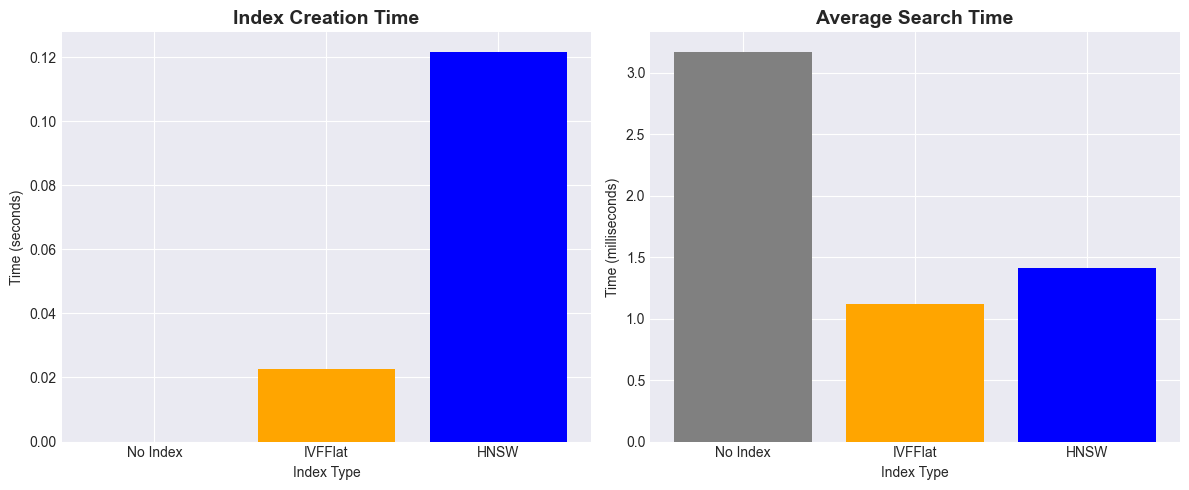

In [10]:
# Create performance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Index creation time
ax1.bar(results_df['Index Type'], results_df['Create Time (s)'], color=['gray', 'orange', 'blue'])
ax1.set_title('Index Creation Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Index Type')

# Search performance
ax2.bar(results_df['Index Type'], results_df['Avg Search (ms)'], color=['gray', 'orange', 'blue'])
ax2.set_title('Average Search Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (milliseconds)')
ax2.set_xlabel('Index Type')

plt.tight_layout()
plt.show()

## Hybrid Search: Combining Vector and SQL

In [11]:
# Demonstrate hybrid search capabilities
print("🔍 Hybrid Search Example\n")

# Query 1: Vector search with metadata filter
query = "database systems"
query_emb = model.encode(query)

hybrid_sql = """
SELECT 
    content,
    1 - (embedding <=> %s::vector) AS similarity,
    metadata->>'category' AS category,
    metadata->>'word_count' AS word_count
FROM documents
WHERE metadata->>'category' = 'database'
ORDER BY embedding <=> %s::vector
LIMIT 3
"""

cursor.execute(hybrid_sql, (query_emb.tolist(), query_emb.tolist()))
results = cursor.fetchall()

print(f"Query: '{query}' (filtered by category='database')\n")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:60]}...")
    print(f"   Similarity: {result['similarity']:.3f}")
    print(f"   Words: {result['word_count']}\n")

🔍 Hybrid Search Example

Query: 'database systems' (filtered by category='database')

1. PostgreSQL is a powerful, open source relational database sy...
   Similarity: 0.658
   Words: 9

2. ACID transactions ensure data consistency in databases....
   Similarity: 0.549
   Words: 7

3. Vector databases enable semantic search using embeddings....
   Similarity: 0.356
   Words: 7



In [12]:
# Query 2: Combine with aggregation
print("\n📊 Aggregated Analysis\n")

agg_sql = """
WITH similarity_scores AS (
    SELECT 
        metadata->>'category' AS category,
        1 - (embedding <=> %s::vector) AS similarity
    FROM documents
)
SELECT 
    category,
    COUNT(*) as doc_count,
    AVG(similarity) as avg_similarity,
    MAX(similarity) as max_similarity
FROM similarity_scores
GROUP BY category
ORDER BY avg_similarity DESC
"""

query = "machine learning and AI"
query_emb = model.encode(query)

cursor.execute(agg_sql, (query_emb.tolist(),))
results = cursor.fetchall()

print(f"Category analysis for query: '{query}'\n")
for result in results:
    print(f"Category: {result['category']}")
    print(f"  Documents: {result['doc_count']}")
    print(f"  Avg Similarity: {result['avg_similarity']:.3f}")
    print(f"  Max Similarity: {result['max_similarity']:.3f}\n")


📊 Aggregated Analysis

Category analysis for query: 'machine learning and AI'

Category: database
  Documents: 3
  Avg Similarity: 0.189
  Max Similarity: 0.268

Category: ml
  Documents: 7
  Avg Similarity: 0.181
  Max Similarity: 0.397



## Advanced Features

### 1. Similarity Threshold Search

In [13]:
# Find documents above similarity threshold
query = "vector similarity search"
query_emb = model.encode(query)
threshold = 0.7

threshold_sql = """
SELECT 
    content,
    1 - (embedding <=> %s::vector) AS similarity
FROM documents
WHERE 1 - (embedding <=> %s::vector) > %s
ORDER BY similarity DESC
"""

cursor.execute(threshold_sql, (query_emb.tolist(), query_emb.tolist(), threshold))
results = cursor.fetchall()

print(f"🎯 Documents with similarity > {threshold} for '{query}':\n")
for result in results:
    print(f"• {result['content']}")
    print(f"  Similarity: {result['similarity']:.3f}\n")

🎯 Documents with similarity > 0.7 for 'vector similarity search':

• Vector similarity search finds related documents efficiently.
  Similarity: 0.794



### 2. Distance Metrics Comparison

In [14]:
# Compare different distance metrics
query = "PostgreSQL database"
query_emb = model.encode(query)

metrics_sql = """
SELECT 
    content,
    embedding <=> %s::vector AS cosine_distance,
    embedding <-> %s::vector AS l2_distance,
    (embedding <#> %s::vector) * -1 AS inner_product
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 3
"""

cursor.execute(
    metrics_sql, 
    (query_emb.tolist(), query_emb.tolist(), query_emb.tolist(), query_emb.tolist())
)
results = cursor.fetchall()

print(f"📏 Distance Metrics for '{query}':\n")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['content'][:50]}...")
    print(f"   Cosine Distance: {result['cosine_distance']:.4f}")
    print(f"   L2 Distance: {result['l2_distance']:.4f}")
    print(f"   Inner Product: {result['inner_product']:.4f}\n")

📏 Distance Metrics for 'PostgreSQL database':

1. PostgreSQL is a powerful, open source relational d...
   Cosine Distance: 0.2959
   L2 Distance: 0.7692
   Inner Product: 0.7041

2. PostgreSQL supports JSON data types natively....
   Cosine Distance: 0.4880
   L2 Distance: 0.9879
   Inner Product: 0.5120

3. pgvector adds vector similarity search to PostgreS...
   Cosine Distance: 0.6039
   L2 Distance: 1.0990
   Inner Product: 0.3961



## Performance Tips

In [ ]:
# Analyze query performance
print("🔧 Query Performance Analysis\n")

# Note: \timing is a psql command and cannot be used in psycopg2
# Instead, we'll use EXPLAIN ANALYZE to see performance details

# Explain query plan
explain_sql = """
EXPLAIN (ANALYZE, BUFFERS)
SELECT content
FROM documents
ORDER BY embedding <=> %s::vector
LIMIT 5
"""

query_emb = model.encode("test query")
cursor.execute(explain_sql, (query_emb.tolist(),))

print("Query Execution Plan:")
for row in cursor.fetchall():
    print(row['QUERY PLAN'])

## RAG Integration Example

In [ ]:
def rag_search(question, context_limit=3):
    """
    Retrieval-Augmented Generation using pgvector
    """
    # Retrieve relevant documents
    query_emb = model.encode(question)
    
    rag_sql = """
    SELECT 
        content,
        1 - (embedding <=> %s::vector) AS similarity
    FROM documents
    ORDER BY embedding <=> %s::vector
    LIMIT %s
    """
    
    cursor.execute(rag_sql, (query_emb.tolist(), query_emb.tolist(), context_limit))
    results = cursor.fetchall()
    
    # Build context
    context_parts = []
    for i, result in enumerate(results, 1):
        context_parts.append(f"{i}. {result['content']} (Relevance: {result['similarity']:.2%})")
    
    context = "\n".join(context_parts)
    
    # Format for LLM
    prompt = f"""
Based on the following context, answer the question.

Context:
{context}

Question: {question}

Answer: [This would be sent to an LLM for generation]
"""
    
    return prompt, results

# Test RAG search
question = "How does pgvector help with semantic search?"
prompt, docs = rag_search(question)

print("🤖 RAG Example\n")
print(f"Question: {question}\n")
print("Retrieved Documents:")
for doc in docs:
    print(f"- {doc['content'][:80]}...")
    print(f"  Relevance: {doc['similarity']:.2%}\n")

print("\nGenerated Prompt (truncated):")
print(prompt[:500] + "...")

## Cleanup

In [ ]:
# Close database connection
cursor.close()
conn.close()
print("✅ Database connection closed")

print("\n📚 Summary:")
print("- pgvector adds vector operations to PostgreSQL")
print("- Supports multiple index types (IVFFlat, HNSW)")
print("- Enables hybrid queries combining vectors and SQL")
print("- Perfect for RAG and enterprise search applications")
print("\nTo stop PostgreSQL: task postgres-stop")

## Conclusion

PostgreSQL with pgvector provides a powerful combination:

1. **ACID Compliance**: Full transactional support for vector operations
2. **SQL Integration**: Combine semantic search with filters, joins, and aggregations
3. **Mature Ecosystem**: Leverage existing PostgreSQL tools and infrastructure
4. **Flexibility**: Choose between different index types based on your needs

### When to Use pgvector vs FAISS:

**Use pgvector when:**
- You need ACID transactions
- You want to combine vector search with SQL queries
- You have existing PostgreSQL infrastructure
- You need full CRUD operations on vectors

**Use FAISS when:**
- You need maximum search performance
- You're working with billions of vectors
- You don't need transactional guarantees
- You want more index options and GPU support

### Next Steps:

1. Experiment with different index parameters
2. Try larger datasets to see performance differences
3. Implement a full RAG system with an LLM
4. Explore partitioning for very large tables
5. Set up monitoring and query optimization

For more information, see the [pgvector documentation](https://github.com/pgvector/pgvector).